In [12]:
pip install -r requirements.txt

     |████████████████████████████████| 24.7 MB 399 kB/s eta 0:00:01
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)


     |████████████████████████████████| 39.8 MB 2.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import petl as etl

In [2]:
# Load file label

label1 = etl.fromtext('rumor_detection_acl2017/twitter15/label.txt')
label1 = label1.capture('lines', '(.*):(.*)$', ['label', 'src_tweet_id'])
label1

label,src_tweet_id
unverified,731166399389962242
unverified,714598641827246081
non-rumor,691809004356501505
non-rumor,693204708933160960
true,551099691702956032


In [3]:
# Load file label

label2 = etl.fromtext('rumor_detection_acl2017/twitter16/label.txt')
label2 = label2.capture('lines', '(.*):(.*)$', ['label', 'src_tweet_id'])
label2

label,src_tweet_id
false,656955120626880512
true,615689290706595840
false,613404935003217920
unverified,731166399389962242
unverified,714598641827246081


In [4]:
# load file source_tweets

source_tweet1 = etl.fromtext('rumor_detection_acl2017/twitter15/source_tweets.txt')
source_tweet1 = source_tweet1.capture('lines', '(.*)\t(.*)$', ['src_tweet_id', 'content'])
source_tweet1

src_tweet_id,content
731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL
714598641827246081,an open letter to trump voters from his top strategist-turned-defector URL via @xojanedotcom
691809004356501505,"""america is a nation of second chances"" —@potus on new reforms to solitary confinement: URL URL"
693204708933160960,"brandon marshall visits and offers advice, support to brother of fallen hero zaevion dobson: URL URL"
551099691702956032,rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away. URL


In [5]:
# load file source_tweets

source_tweet2 = etl.fromtext('rumor_detection_acl2017/twitter16/source_tweets.txt')
source_tweet2 = source_tweet2.capture('lines', '(.*)\t(.*)$', ['src_tweet_id', 'content'])
source_tweet2

src_tweet_id,content
656955120626880512,correct predictions in back to the future ii URL
615689290706595840,.@whitehouse in rainbow colors for #scotusmarriage? here's what i think about that decision: URL
613404935003217920,cops bought the alleged church shooter burger king hours after killings URL
731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL
714598641827246081,an open letter to trump voters from his top strategist-turned-defector URL via @xojanedotcom


In [6]:
# join table berdasarkan source tweet id
# rename header sesuai dengan codingan asal

tweet_text1 = etl.join(label1, source_tweet1, key='src_tweet_id')
tweet_text1 = etl.cut(tweet_text1, 'label', 'content')
tweet_text1 = etl.setheader(tweet_text1, ['category', 'text'])
tweet_text1

category,text
false,deep-fried left wings demo-crab cakes barack-amole & chips malia quesadillas hawaiian pizza sloppy joe bidens obamacare-rot cake
false,42 million dead in bloodiest black friday weekend on record URL
false,42 million dead in bloodiest black friday weekend on record URL
true,#prayforchristopher 5k run .. well we are walking lol @savannahn_2012 @lemongella URL
false,a photo of black nurses saving the life of a kkk member. URL


In [7]:
tweet_text2 = etl.join(label2, source_tweet2, key='src_tweet_id')
tweet_text2 = etl.cut(tweet_text2, 'label', 'content')
tweet_text2 = etl.setheader(tweet_text2, ['category', 'text'])
tweet_text2

category,text
true,witness: police allegedly stopped mike brown after yelling at him to walk on sidewalk. #ferguson URL
true,"oh. so now the #ferguson police chief says the cop didn't know about the robbery when he stopped #mikebrown. the kid was ""jaywalking""? bs!"
true,only photo i will tweet. cpr being performed on the soldier now. i heard four shots. #ottawa URL
true,shots fired on parliament hill after a man walked up with a gun. i'm locked in a security office on parliament hill
true,breaking - shooting on parliament hill. rcmp have weapons drawn #cdnpoli URL


In [ ]:
# untuk mengetahui labelnya apa saja

tweet_text1.distinct('category')

In [ ]:
tweet_text2.distinct('category')

In [ ]:
print(len(tweet_text1))
print(len(tweet_text2))
len(tweet_text1)+len(tweet_text2)

In [ ]:
# menyimpan ke file csv

etl.tocsv(tweet_text1, 'tweet-text-1.csv')
etl.appendcsv(tweet_text2, 'tweet-text-1.csv')

In [8]:
tweet_text3 = etl.select(tweet_text1, "{category} == 'true' or {category} == 'false'")
tweet_text3 = etl.convert(tweet_text3, 'category', 'replace', 'true', 'ya')
tweet_text3 = etl.convert(tweet_text3, 'category', 'replace', 'false', 'tidak')

tweet_text4 = etl.select(tweet_text2, "{category} == 'true' or {category} == 'false'")
tweet_text4 = etl.convert(tweet_text4, 'category', 'replace', 'true', 'ya')
tweet_text4 = etl.convert(tweet_text4, 'category', 'replace', 'false', 'tidak')

etl.tocsv(tweet_text3, 'tweet-text-binary.csv')
etl.appendcsv(tweet_text4, 'tweet-text-binary.csv')

In [2]:
# datapath = 'bbc-text.csv'
datapath = 'tweet-text-binary.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tidak,deep-fried left wings demo-crab cakes barack-a...
1,tidak,42 million dead in bloodiest black friday week...
2,tidak,42 million dead in bloodiest black friday week...
3,ya,#prayforchristopher 5k run .. well we are walk...
4,tidak,a photo of black nurses saving the life of a k...


<AxesSubplot:xlabel='category'>

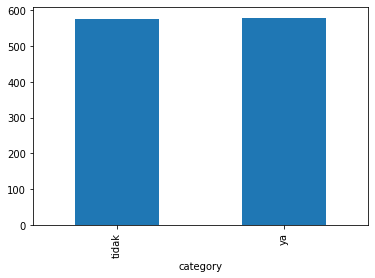

In [3]:
df.groupby(['category']).size().plot.bar()

In [4]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# labels = {'business':0,
#           'entertainment':1,
#           'sport':2,
#           'tech':3,
#           'politics':4
#           }
# labels = {'false':0,
#           'non-rumor':1,
#           'true':2,
#           'unverified':3,
#           }
labels = {'tidak':0,
          'ya':1,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [5]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

923 115 116


In [6]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, 4)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [7]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 20
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:40<00:00, 11.

Epochs: 1 | Train Loss:  0.352                 | Train Accuracy:  0.504                 | Val Loss:  0.349                 | Val Accuracy:  0.574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.22it/s]


Epochs: 2 | Train Loss:  0.327                 | Train Accuracy:  0.635                 | Val Loss:  0.325                 | Val Accuracy:  0.661


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.17it/s]


Epochs: 3 | Train Loss:  0.283                 | Train Accuracy:  0.763                 | Val Loss:  0.289                 | Val Accuracy:  0.774


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:43<00:00, 10.57it/s]


Epochs: 4 | Train Loss:  0.229                 | Train Accuracy:  0.818                 | Val Loss:  0.272                 | Val Accuracy:  0.809


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:42<00:00, 10.88it/s]


Epochs: 5 | Train Loss:  0.180                 | Train Accuracy:  0.883                 | Val Loss:  0.248                 | Val Accuracy:  0.809


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.08it/s]


Epochs: 6 | Train Loss:  0.130                 | Train Accuracy:  0.925                 | Val Loss:  0.180                 | Val Accuracy:  0.861


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.04it/s]


Epochs: 7 | Train Loss:  0.097                 | Train Accuracy:  0.951                 | Val Loss:  0.184                 | Val Accuracy:  0.870


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.15it/s]


Epochs: 8 | Train Loss:  0.075                 | Train Accuracy:  0.966                 | Val Loss:  0.237                 | Val Accuracy:  0.791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.03it/s]


Epochs: 9 | Train Loss:  0.063                 | Train Accuracy:  0.970                 | Val Loss:  0.219                 | Val Accuracy:  0.843


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.23it/s]


Epochs: 10 | Train Loss:  0.056                 | Train Accuracy:  0.973                 | Val Loss:  0.225                 | Val Accuracy:  0.826


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.17it/s]


Epochs: 11 | Train Loss:  0.048                 | Train Accuracy:  0.973                 | Val Loss:  0.249                 | Val Accuracy:  0.817


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.13it/s]


Epochs: 12 | Train Loss:  0.042                 | Train Accuracy:  0.973                 | Val Loss:  0.273                 | Val Accuracy:  0.791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.17it/s]


Epochs: 13 | Train Loss:  0.037                 | Train Accuracy:  0.973                 | Val Loss:  0.288                 | Val Accuracy:  0.817


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.20it/s]


Epochs: 14 | Train Loss:  0.028                 | Train Accuracy:  0.973                 | Val Loss:  0.273                 | Val Accuracy:  0.809


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.22it/s]


Epochs: 15 | Train Loss:  0.029                 | Train Accuracy:  0.973                 | Val Loss:  0.276                 | Val Accuracy:  0.817


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.08it/s]


Epochs: 16 | Train Loss:  0.029                 | Train Accuracy:  0.971                 | Val Loss:  0.285                 | Val Accuracy:  0.826


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:42<00:00, 10.86it/s]


Epochs: 17 | Train Loss:  0.028                 | Train Accuracy:  0.972                 | Val Loss:  0.247                 | Val Accuracy:  0.878


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.13it/s]


Epochs: 18 | Train Loss:  0.025                 | Train Accuracy:  0.973                 | Val Loss:  0.222                 | Val Accuracy:  0.861


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:41<00:00, 11.19it/s]


Epochs: 19 | Train Loss:  0.021                 | Train Accuracy:  0.973                 | Val Loss:  0.242                 | Val Accuracy:  0.843


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [00:42<00:00, 10.94it/s]


Epochs: 20 | Train Loss:  0.021                 | Train Accuracy:  0.973                 | Val Loss:  0.254                 | Val Accuracy:  0.852


In [115]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    result = []
    label_result = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)  
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              result.append(output.cpu().numpy()[0])
#               label_result.append(output.argmax(dim=1).cpu().numpy()[0])
              label_result.append(test_label.cpu().numpy()[0])

              acc = (output.argmax(dim=1) == test_label).sum().item()
              
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return [np.array(result, dtype=np.float32), np.array(label_result, dtype=np.int8)]

In [76]:
evaluate(model, df_test)

Test Accuracy:  0.819


[array([[6.9617942e-02, 4.2839174e+00],
        [3.5228026e+00, 1.2508199e+00],
        [0.0000000e+00, 4.5101700e+00],
        [4.7159576e+00, 0.0000000e+00],
        [4.3042765e+00, 0.0000000e+00],
        [2.2198458e+00, 0.0000000e+00],
        [2.4448587e-01, 6.2579679e+00],
        [2.1455162e+00, 3.2428536e+00],
        [1.4734931e+00, 4.8267660e+00],
        [2.1804850e+00, 2.4526784e+00],
        [4.5194573e+00, 6.4557076e-01],
        [3.8158970e+00, 0.0000000e+00],
        [2.0829098e+00, 2.3194933e+00],
        [1.6926479e+00, 3.7144153e+00],
        [4.8253198e+00, 0.0000000e+00],
        [4.3874183e+00, 4.0930361e-03],
        [1.3864566e+00, 0.0000000e+00],
        [0.0000000e+00, 6.5284567e+00],
        [3.0893460e-01, 5.0847607e+00],
        [4.8077168e+00, 0.0000000e+00],
        [1.7331672e-01, 6.0517921e+00],
        [4.9439883e+00, 0.0000000e+00],
        [0.0000000e+00, 5.8009605e+00],
        [5.5478644e-01, 5.3715019e+00],
        [0.0000000e+00, 4.6412973e+00],


In [116]:
vectorized_data, label_vectorized_data = evaluate(model, df)

Test Accuracy:  0.944


In [117]:
vectorized_data

array([[4.614884  , 0.        ],
       [5.259606  , 0.21752948],
       [4.6566334 , 0.03835768],
       ...,
       [4.251071  , 0.        ],
       [1.2723016 , 5.9410295 ],
       [4.8056674 , 0.        ]], dtype=float32)

In [118]:
label_vectorized_data

array([0, 0, 0, ..., 0, 1, 0], dtype=int8)

In [119]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_data, label_vectorized_data,
                                                    stratify=label_vectorized_data, random_state=1)
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(4,), max_iter=1000).fit(X_train, y_train)

In [120]:
clf.predict_proba(X_test)

array([[0.9114647 , 0.08853532],
       [0.9114647 , 0.08853532],
       [0.07155186, 0.92844814],
       [0.02311158, 0.9768884 ],
       [0.04016387, 0.9598361 ],
       [0.0134393 , 0.9865607 ],
       [0.9114647 , 0.08853532],
       [0.9114647 , 0.08853532],
       [0.9114647 , 0.08853532],
       [0.9114647 , 0.08853532],
       [0.01301575, 0.98698425],
       [0.03636253, 0.9636375 ],
       [0.83386075, 0.16613923],
       [0.9114647 , 0.08853532],
       [0.5526266 , 0.44737342],
       [0.01683486, 0.98316514],
       [0.04170495, 0.95829505],
       [0.01155227, 0.9884477 ],
       [0.02486008, 0.9751399 ],
       [0.0280903 , 0.9719097 ],
       [0.03200567, 0.96799433],
       [0.0357269 , 0.9642731 ],
       [0.00899762, 0.9910024 ],
       [0.9114647 , 0.08853532],
       [0.9114647 , 0.08853532],
       [0.0066604 , 0.9933396 ],
       [0.9114647 , 0.08853532],
       [0.9114647 , 0.08853532],
       [0.9114647 , 0.08853532],
       [0.9114647 , 0.08853532],
       [0.

In [121]:
clf.predict(X_test)

array([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1], dtype=int8)

In [122]:
clf.score(X_test, y_test)

0.9550173010380623